In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import os
import warnings
import scipy
import scipy.optimize

from sklearn.metrics import r2_score


In [2]:
def list_hdf5_files(start_path):
    hdf5_files = []
    for root, dirs, files in os.walk(start_path):
        for file in files:
            if file.endswith('.hdf5'):
                hdf5_files.append(os.path.join(root, file))
    return hdf5_files


def moving_average(data, window_size):   
    extended_data = np.concatenate([data, data[:window_size-1]])  # Extend the data for wrapping
    return np.convolve(extended_data, np.ones(window_size), 'valid')[:len(data)] / window_size

def param_cos(x, a, b, c, d):
    return a * np.sqrt(np.abs(np.cos(b * (x - c)))) + d

In [3]:
data_dir = "qubit voltage sweep"
DATA_ROOT = "data"

path = os.path.join(DATA_ROOT, data_dir)

hdf5_files = list_hdf5_files(path)
hdf5_files

['data\\qubit voltage sweep\\000140_QubitSpectroscopy_continuous_qb1\\000140_QubitSpectroscopy_continuous_qb1.hdf5',
 'data\\qubit voltage sweep\\113301_QubitSpectroscopy_continuous_qb1\\113301_QubitSpectroscopy_continuous_qb1.hdf5',
 'data\\qubit voltage sweep\\142720_QubitSpectroscopy_continuous_qb1\\142720_QubitSpectroscopy_continuous_qb1.hdf5',
 'data\\qubit voltage sweep\\145526_QubitSpectroscopy_continuous_qb1\\145526_QubitSpectroscopy_continuous_qb1.hdf5']

In [4]:
f = h5py.File(hdf5_files[3])
data = np.array(list(f["Experimental Data"]["Data"]))
freqs = np.array(list(f["Experimental Data"]["Experimental Metadata"]["task_list"]["list_idx_0"]["freqs"])) * 1e-9
volts = np.array(list(f["Experimental Data"]["Experimental Metadata"]["task_list"]["list_idx_0"]["volts"]))

if len(data) != len(freqs) * len(volts):
    warnings.warn("The dataset doesn't seem to be complete")
    data = np.zeros((len(freqs) * len(volts), 4))
    temp = np.array(list(f["Experimental Data"]["Data"]))
    data[:len(temp)] = temp
    data[len(temp):] = np.min(temp)

In [5]:
y = np.abs(data[:,2] + 1j * data[:,3])
y = np.reshape(y, (len(volts), len(freqs)))
y = np.flipud(y)


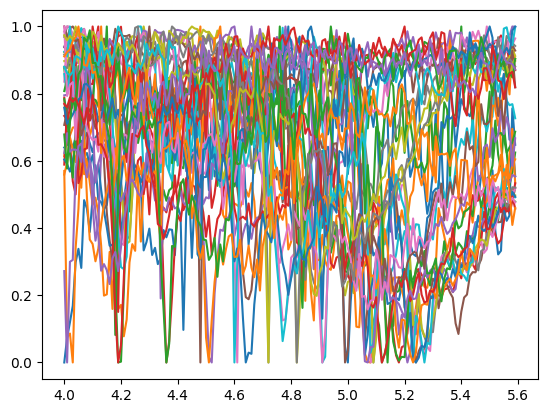

In [6]:
for i in y:
    plt.plot(freqs, (i - np.min(i))/(np.max(i) - np.min(i)))
    #plt.show()
    #plt.close()

In [7]:
def find_local_peaks(x, data, start_x, delta_x = 0.1, delta_y = 0.001, debug = False):
    # find start index
    start_i = np.min(np.where(x >= start_x))
    delta_i = int(delta_x/(x[1] - x[0]))

    current_i = start_i
    last_i = start_i

    current_y = data[0, start_i]
    last_y = data[0, start_i]

    all_mins = []
    for i, y, in enumerate(data):
        # lets normalize
        y = (y - np.min(y))/(np.max(y) - np.min(y))

        #search in a small range that is decided by delta x
        last_i = current_i
        last_y = current_y

        min_i = max(last_i - delta_i, 0)
        max_i = min(last_i + delta_i, len(y))

        y_threshold_index = np.where((y <= last_y + delta_y) & (y >= last_y - delta_y))[0]
        if len(y_threshold_index) == 0:
            current_i = np.argmin(y[min_i:max_i]) + min_i
        else:        
            y_threshold_index = y_threshold_index[np.where((y_threshold_index >= min_i) & (y_threshold_index <= max_i))]
            if len(y_threshold_index) == 0:
                y_threshold_index = np.where((y <= last_y + delta_y) & (y >= last_y - delta_y))[0]
                current_i = y_threshold_index[np.argmin(y[y_threshold_index])]
            else:
                current_i = np.argmin(y[min_i:max_i]) + min_i

        current_y = y[current_i]

        all_mins.append(current_i)

        if debug:
            fig, ax = plt.subplots(2)
            ax[0].plot(x, y)
            ax[0].scatter(x[y_threshold_index], y[y_threshold_index], marker="x", color="orange")
            ax[0].axvline(x[min_i], color="green")
            ax[0].axvline(x[max_i], color="green")
            ax[0].axhline(last_y + delta_y, color="green")
            ax[0].axhline(last_y - delta_y, color="green")
            ax[0].axvline(x[current_i], color="red", label=f"Min at {x[current_i]}")
            ax[0].axvline(x[last_i], color="yellow")
            ax[1].plot(x[min_i:max_i], y[min_i:max_i])
            ax[1].axvline(x[current_i], color="red", label=f"Min at {x[current_i]}")
            ax[1].axvline(x[last_i], color="yellow")
            
            ax[1].axhline(last_y + delta_y, color="green")
            ax[1].scatter(x[y_threshold_index], y[y_threshold_index], marker="x", color="orange")
            ax[1].axhline(last_y - delta_y, color="green")
            plt.show()
            plt.close()
            
    return x[all_mins]

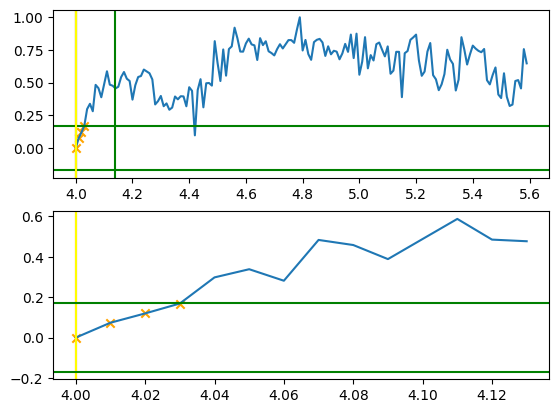

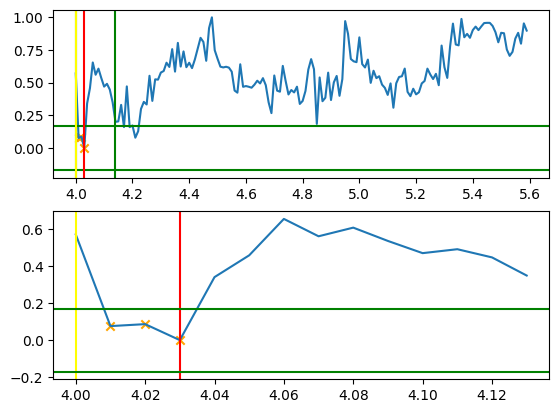

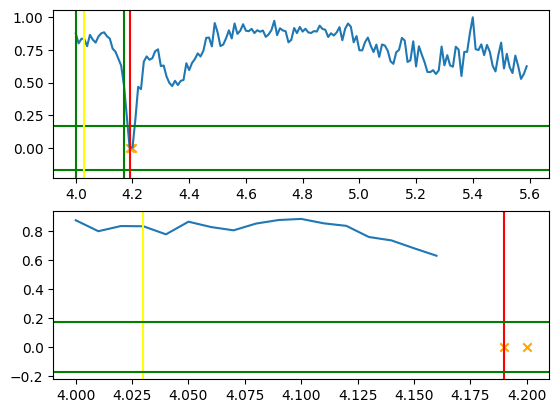

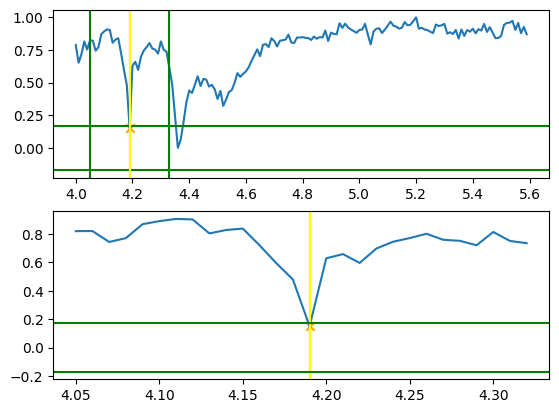

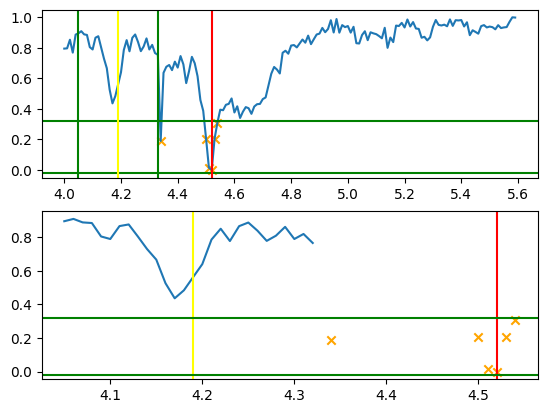

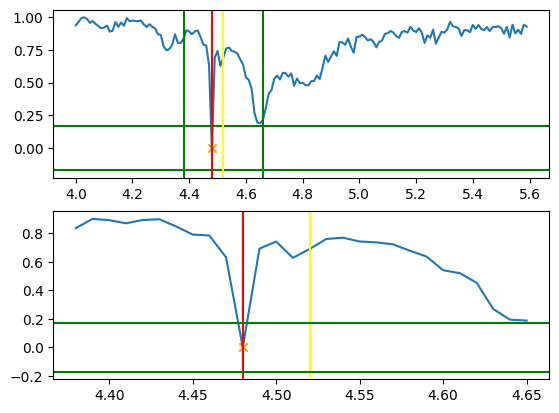

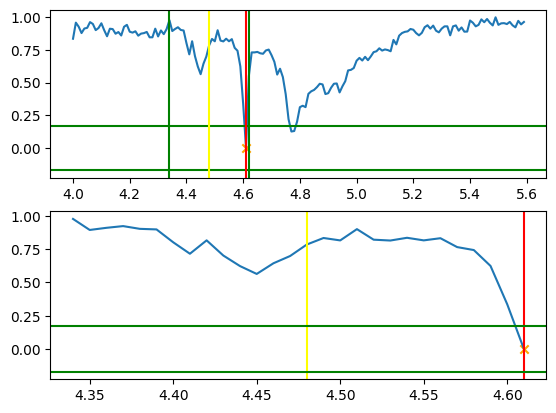

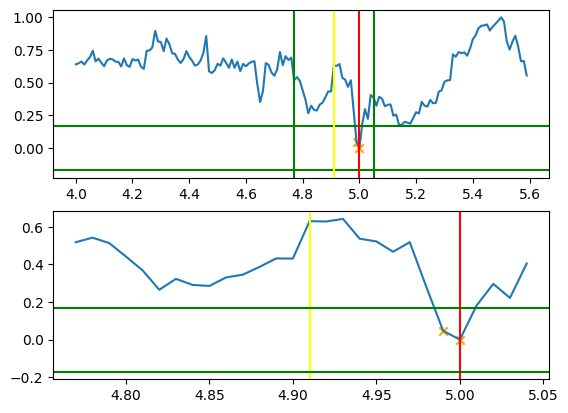

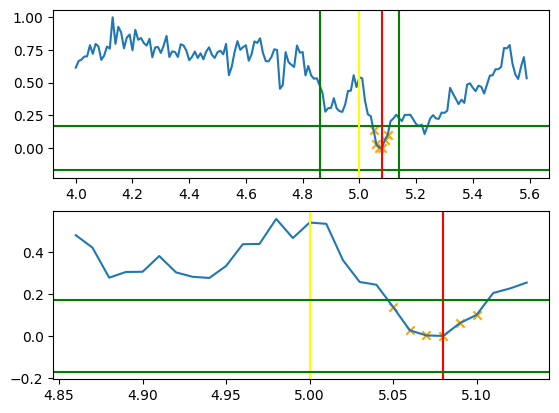

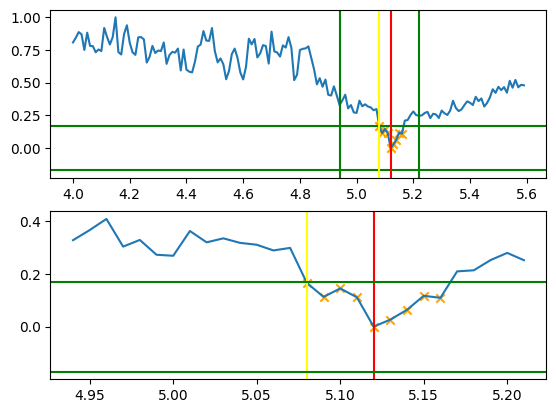

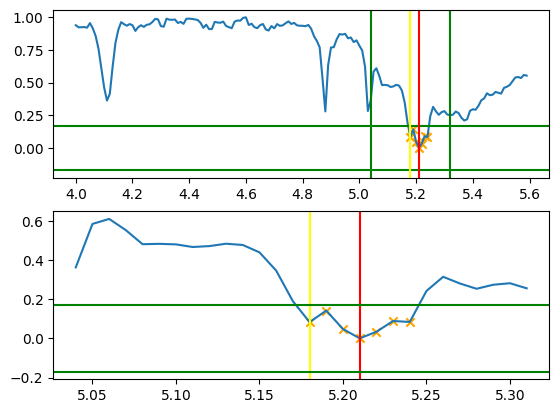

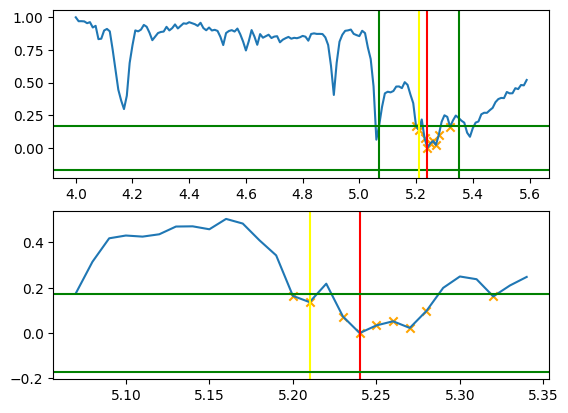

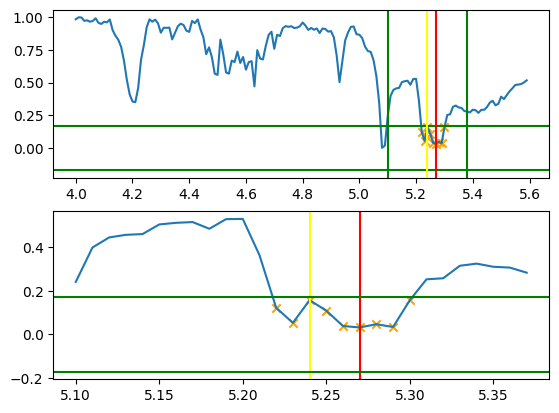

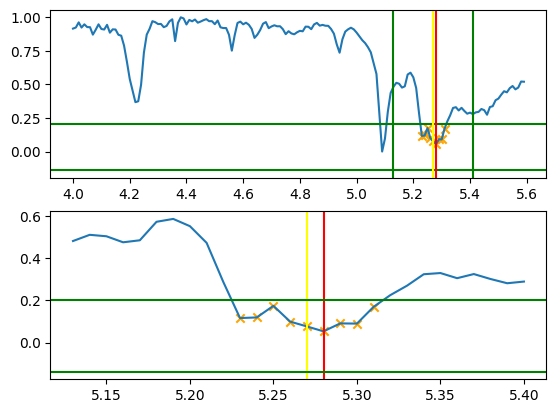

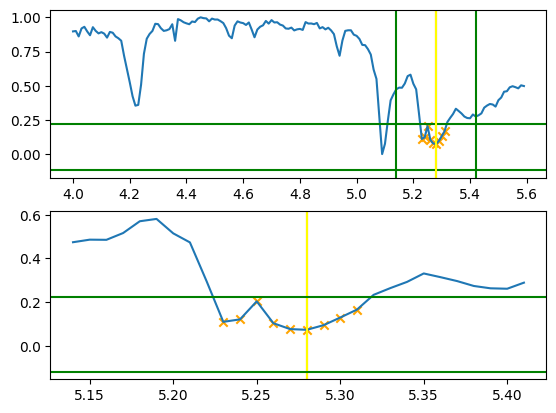

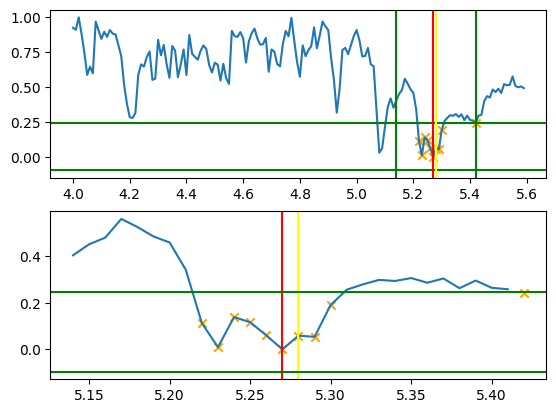

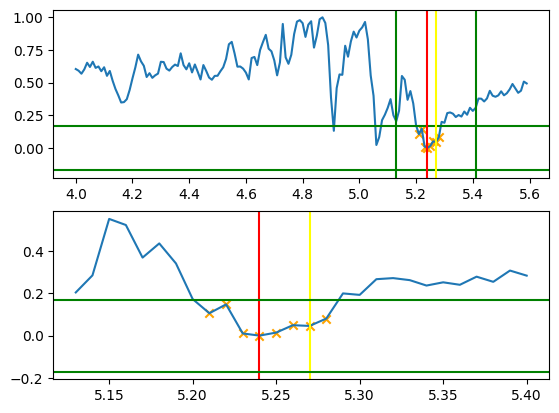

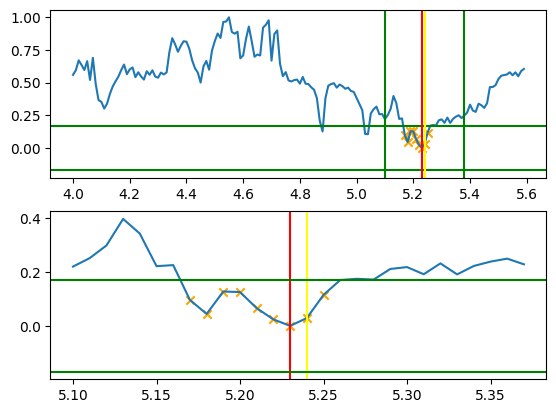

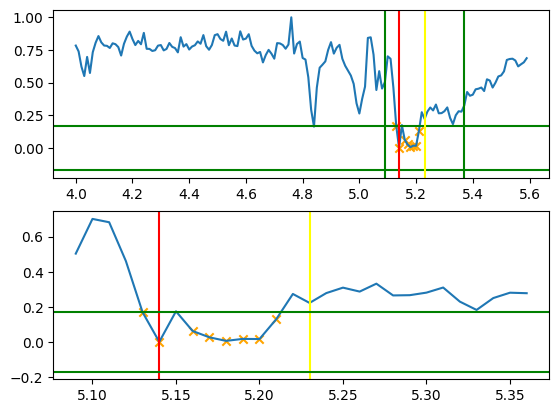

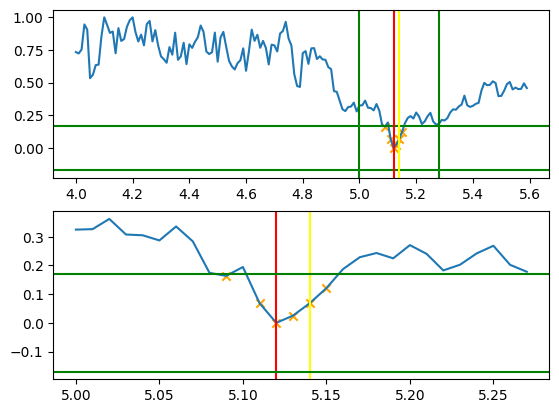

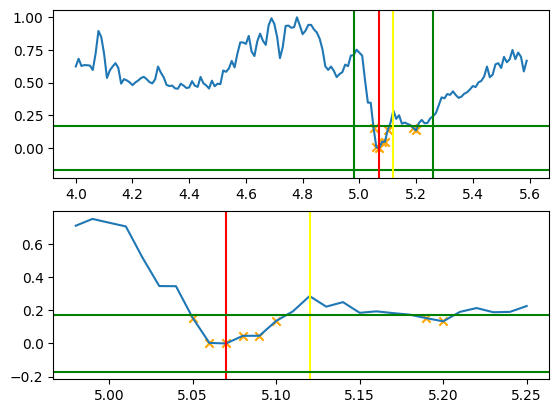

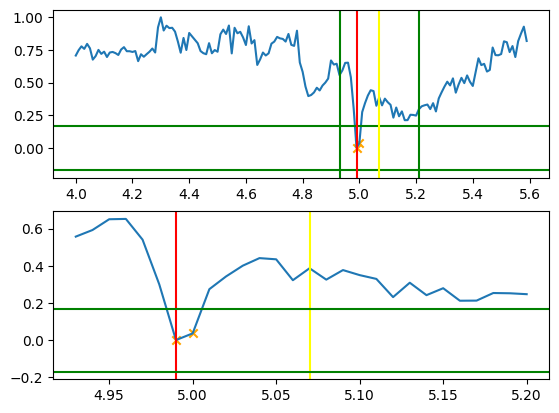

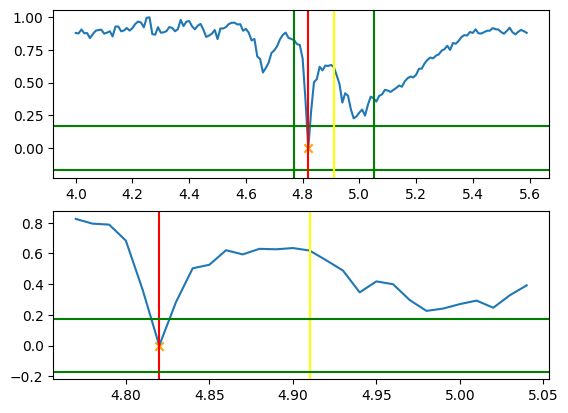

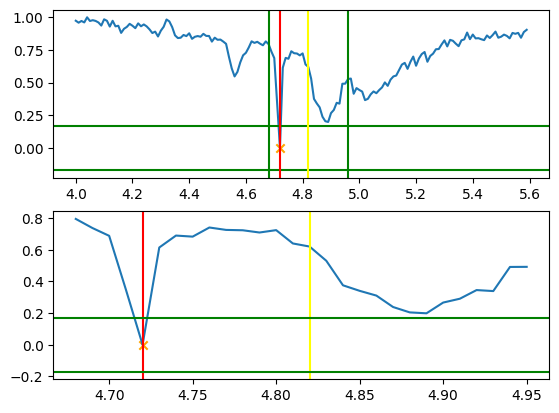

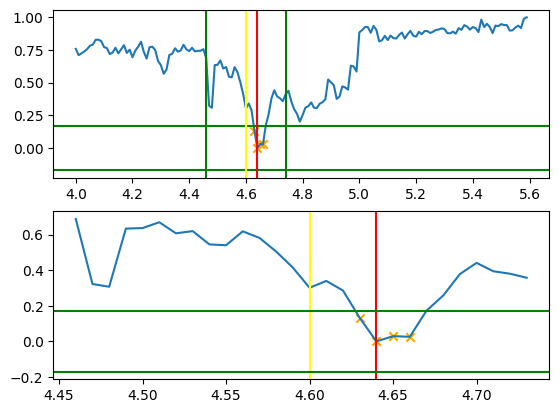

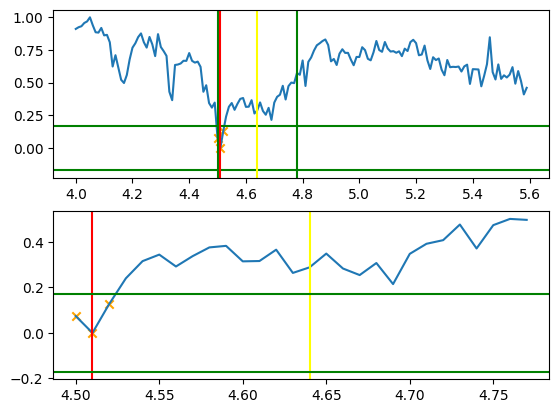

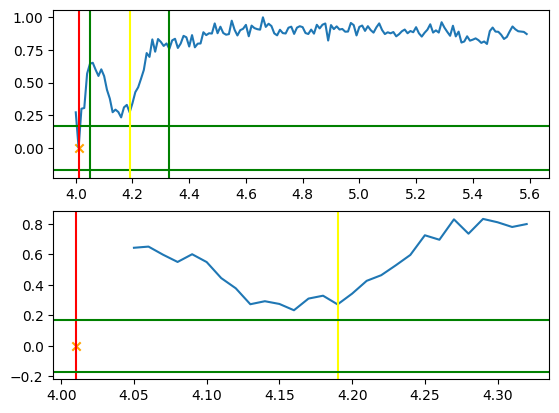

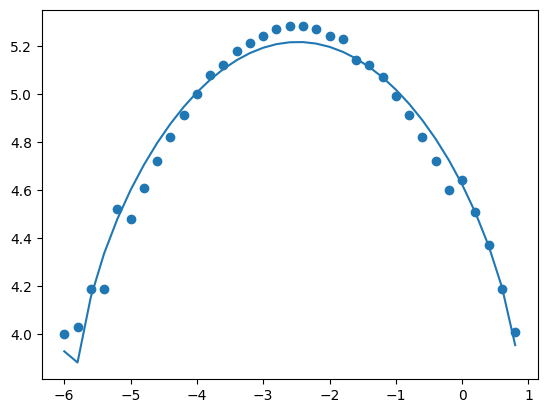

In [8]:
min_freq = find_local_peaks(freqs, y, 4, 0.15, 0.17, True)
(a, b, c, d), cov = scipy.optimize.curve_fit(param_cos, volts, min_freq, [1.2, 0.45, -2.5, 4])
plt.scatter(volts, min_freq)
plt.plot(volts, param_cos(volts, a, b, c, d))

In [9]:
min_freq = []
for i in y:
    temp = moving_average(i, 10)
    min_freq.append(freqs[np.argmin(temp)])

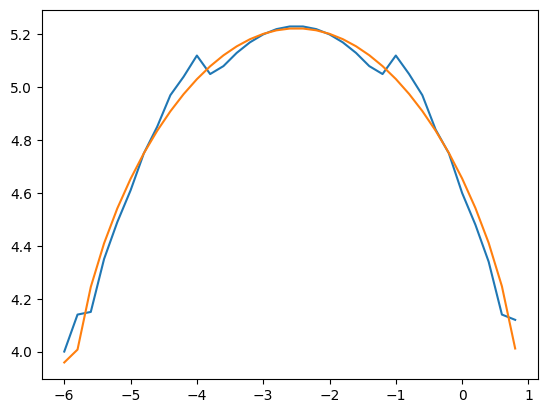

In [10]:
(a, b, c, d), cov = scipy.optimize.curve_fit(param_cos, volts, min_freq, [1.2, 0.45, -2.5, 4])
plt.plot(volts, min_freq)
plt.plot(volts, param_cos(volts, a, b, c, d))

In [11]:
r2_score(min_freq, param_cos(volts, a, b, c, d))

0.9787539440611993

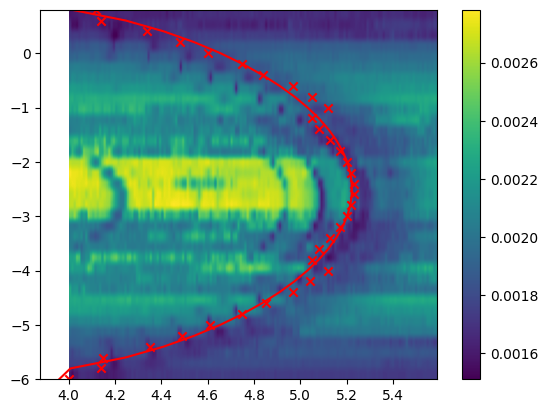

In [12]:
im = plt.imshow(y, aspect='auto', extent=[np.min(freqs), np.max(freqs), np.min(volts), np.max(volts)])
plt.colorbar(im)
plt.scatter(min_freq, volts, color="red", marker="x")
plt.plot(param_cos(volts, a, b, c, d), volts, color="red")
plt.show()